# Evaluate a sine and pulse network

Shows how to:
- load the outputs of training or generate predictions anew.
- generate diagnostic plots to evaluate network performance and detect and troubleshoot any issues.

__Note:__ For this tutorial to work, you first need to download example data and models (266MB) from [here](https://www.dropbox.com/sh/wnj3389k8ei8i1c/AACy7apWxW87IS_fBjI8-7WDa?dl=0) and put the four folders in the `tutorials` folder.

In [1]:
%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page

import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import librosa.feature, librosa.display
from pprint import pprint
import das.utils, das.utils_plot, das.predict, das.event_utils, das.segment_utils, das.io, das.evaluate
from tqdm.autonotebook import tqdm

plt.style.use('ncb.mplstyle')

/Users/janc/Dropbox/code.py/das/src/das/data.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


`save_name` should be the stem common to all files produced during training.
For instance, if the parameter file for the model is `res/20191121_094529_params.yaml`, then `save_name` should be `res/20191121_094529`.

The tutorials come with two networks for Dmel pulse song:
- `models/dmel_pulse_tcn_single_channel/` is an optimal model for dmel single-channel pulse song
- `res/20191128_170521` is a smaller TCN model  trained for 20 epochs on the toy data set produced by [1_prepare_data.ipynb](1_prepare_data.ipynb) and trained with the parameters in [2_training.ipynb](2_training.ipynb).

In [2]:
# path with prefix to the files generated during training
save_name = 'models/dmel_all/20200507_173738'  # single-channel dmel pulse and sine model

# load parameters
params = das.utils.load_params(save_name)
pprint(params)
fs = params['samplerate_x_Hz']

# Check whether the model predicts segments and/or events
try: 
    segment_pred_index = params['class_types'][1:].index('segment') + 1
    print(f'model predicts segments at index {segment_pred_index}')
except ValueError:
    print('model does not predict segments.')
    segment_pred_index = None
   
try: 
    pulse_pred_index = params['class_types'].index('event')    
    print(f'model predicts pulses at index {pulse_pred_index}')
except ValueError:
    print('model does not predict pulse.')
    pulse_pred_index = None

{'batch_level_subsampling': False,
 'batch_norm': True,
 'batch_size': 32,
 'class_names': ['noise', 'sine', 'pulse'],
 'class_names_pulse': ['noise', 'pulse'],
 'class_names_sine': ['noise', 'sine'],
 'class_types': ['segment', 'segment', 'event'],
 'class_types_pulse': ['segment', 'event'],
 'class_types_pulse_fss': ['segment', 'event'],
 'class_types_sine': ['segment', 'segment'],
 'class_types_sine_fss': ['segment', 'segment'],
 'data_dir': '../dat/dmel_single_stern_raw.npy',
 'data_padding': 96,
 'eventtimes_units': 'seconds',
 'filename_endsample_test': [],
 'filename_endsample_train': [],
 'filename_endsample_val': [],
 'filename_startsample_test': [],
 'filename_startsample_train': [],
 'filename_startsample_val': [],
 'filename_test': [],
 'filename_train': [],
 'filename_val': [],
 'first_sample_train': 0,
 'first_sample_val': 0,
 'fraction_data': None,
 'ignore_boundaries': True,
 'kernel_size': 32,
 'last_sample_train': None,
 'last_sample_val': None,
 'model_name': 'tcn',


## Predict song
Either load audio (`x_test`), ground truth labels (`y_test`), and confidence scores (`y_pred`) from `_results.h5` generated after training or load the data set and run the model.

The confidence scores are post-processed to detect events and label segments. During postprocessing events can be filtered by interval (`event_dist_min`, `event_dist_max`, not used here),
and short segments can be removed (`segment_minlen=0.02`) or brief gaps filled (`segment_fillgap=0.02`).

In [3]:
# Load training data set - path is in params['data_dir']. If you trained on a different machine set a custom path 
params['data_dir'] = 'dat/dmel_single_stern_raw.npy'
data = das.io.load(params['data_dir'])
x_test = data['test']['x']
y_test = data['test']['y'].astype(float)
# create confidence scores by running the models and predict events and segments
events, segments, y_pred, _ = das.predict.predict(x_test, model_save_name=save_name, verbose=1, batch_size=1, segment_minlen=0.02, segment_fillgap=0.02)
# y_pred = y_pred.compute()
# print(type(y_pred))
# print('events')
# [print(key, type(val)) for key, val in events.items()]
# print('segments')
# [print(key, type(val)) for key, val in segments.items()]

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



/Users/janc/miniconda3/envs/dev/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: dss.tcn.tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
2022-09-25 19:23:21.875572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-25 19:23:21.875906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/316 [00:00<?, ?it/s]

2022-09-25 19:23:22.716655: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-25 19:23:22.717541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Inspect the raw confidence scores
The DAS network produces a confidence score for each sample, which correspond to the probability of finding a specific song type at that sample. The confidence score is post-processed to create annotations - detect the times of events  and label segments.



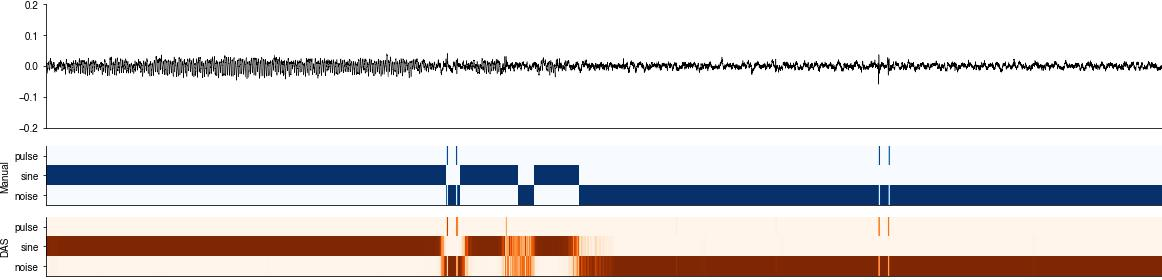

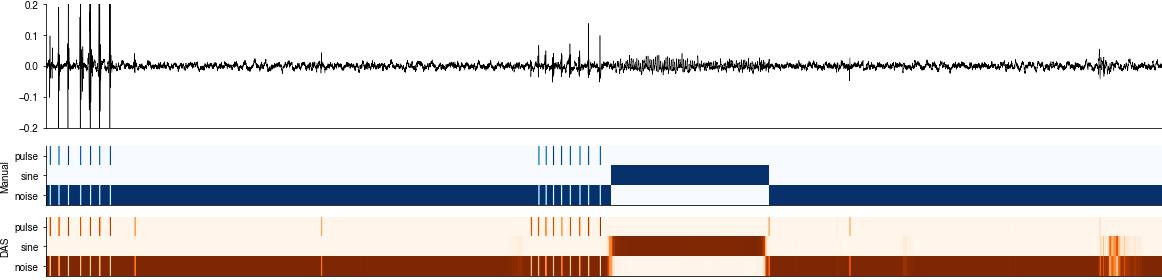

In [4]:
for t0 in [160_000, 270_000]:
    t1 = int(t0 + 40_000)
    
    plt.figure(figsize=(20,5))
    plt.subplot(211)
    plt.plot(x_test[t0:t1], c='k', linewidth=0.5)
    plt.xlim(0, (t1-t0))
    plt.ylim(-0.2, 0.2)
    plt.xticks([])
    das.utils_plot.remove_axes()

    plt.subplot(413)
    plt.imshow(y_test[t0:t1].T, cmap='Blues')

    plt.yticks(range(len(params['class_names'])), labels=params['class_names'])
    plt.ylabel('Manual')
    plt.xticks([])
    das.utils_plot.remove_axes()

    plt.subplot(414)
    plt.imshow(y_pred[t0:t1].T, cmap='Oranges')
    plt.yticks(range(len(params['class_names'])), labels=params['class_names'])
    plt.ylabel('DAS')
    plt.xticks([])
    das.utils_plot.remove_axes()
    

## Evaluate events
Evaluate event timing and compute performance metrics.

In [5]:
def prc_pulse(pred_pulse, pulsetimes_true, fs, tol, min_dist, index=0, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0, 1.01, 0.01)
    precision = []
    recall = []
    f1_score = []
    threshold = []

    for thres in tqdm(thresholds):
        pulsetimes_pred, pulsetimes_pred_confidence = das.event_utils.detect_events(pred_pulse, thres=thres, min_dist=min_dist, index=index)
        pulsetimes_pred = pulsetimes_pred / fs
        d, nn_pred_pulse, nn_true_pulse, nn_dist = das.event_utils.evaluate_eventtimes(pulsetimes_true, pulsetimes_pred, fs, tol)
        precision.append(d['precision'])
        recall.append(d['recall'])
        f1_score.append(d['f1_score'])
        threshold.append(thres)
    return threshold, precision, recall, f1_score

# Evaluate events based on timing, allowing for some tolerance
tol = .01  # seconds = 10ms
min_dist = 0.01
    
if pulse_pred_index is not None:
    pulsetimes_true, _ = das.event_utils.detect_events(y_test, thres=0.5, min_dist=0.01 * fs, index=pulse_pred_index)
    pulsetimes_true =  pulsetimes_true / fs
    pulsetimes_pred = np.array(events['seconds'])

    # # # Evalute event times (match predicted pulse times to their nearest true pulses)
    d, nn_pred_pulse, nn_true_pulse, nn_dist = das.event_utils.evaluate_eventtimes(pulsetimes_true, pulsetimes_pred, fs, tol)
    
    print(f"FP {d['FP']}, TP {d['TP']}, FN {d['FN']}")
    print(f"precision {d['precision']:1.2f}, recall {d['recall']:1.2f}, f1-score {d['f1_score']:1.2f}")
    
    # calc performance metrics (precision, recall, f1 score) for different thresholds
    threshold, precision, recall, f1_score = prc_pulse(y_pred, pulsetimes_true, fs, tol, min_dist * fs, index=pulse_pred_index)

FP 49, TP 634, FN 7
precision 0.93, recall 0.99, f1-score 0.96


  0%|          | 0/101 [00:00<?, ?it/s]

### Event sequences
First, inspect the sequences of true and the predicted event times. They should track each other closely.

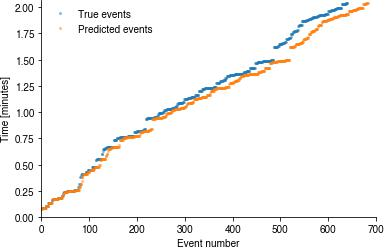

In [6]:
if pulse_pred_index is not None:
    plt.plot(pulsetimes_true / 60, '.', alpha=0.5)
    plt.plot(pulsetimes_pred / 60, '.', alpha=0.5)
    plt.legend(['True events', 'Predicted events'])
    plt.xlabel('Event number')
    plt.ylabel('Time [minutes]')
    plt.ylim(0, x_test.shape[0] / fs / 60 * 1.01)

### Performance metrics
- precision vs recall for different decision thresholds (color-coded). The closer to the upper right corner the better.   
- F1-score for different decision thresholds. The higher the better.  

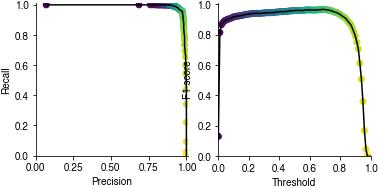

In [7]:
if pulse_pred_index is not None:
    plt.subplot(121)
    plt.plot(precision, recall, c='k')
    plt.scatter(precision, recall, c=threshold)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.axis('square')
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)

    plt.subplot(122)
    plt.plot(threshold, f1_score, c='k')
    plt.scatter(threshold, f1_score, c=threshold)
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1.01)

### Event timing
The sequence (left) and the distribution (right) of temporal errors (dist to nearest event). Black lines indicate the distance threshold within which true and predicted events are matched. This will reveal drifts in event timing. 

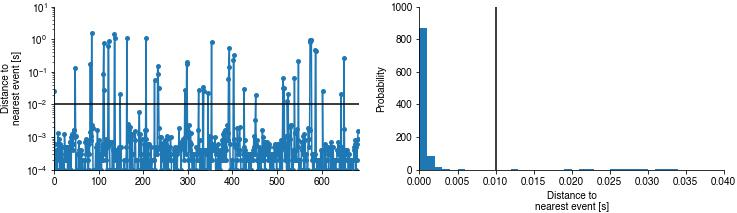

In [8]:
if pulse_pred_index is not None:
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.plot(nn_dist, '.-', markersize=10)
    plt.xlim(0, len(nn_dist))
    plt.axhline(tol, color='k')
    plt.yscale('log')
    plt.ylabel('Distance to\nnearest event [s]')
    
    plt.subplot(122)
    plt.hist(nn_dist, bins=np.arange(0, 4 * tol, .001), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to\nnearest event [s]')
    plt.ylabel('Probability');

### Event shapes
Plot the shapes of false/true positive/negative pulses - if you use the network trained on the toy data set, most false positives arise from annotations errors.

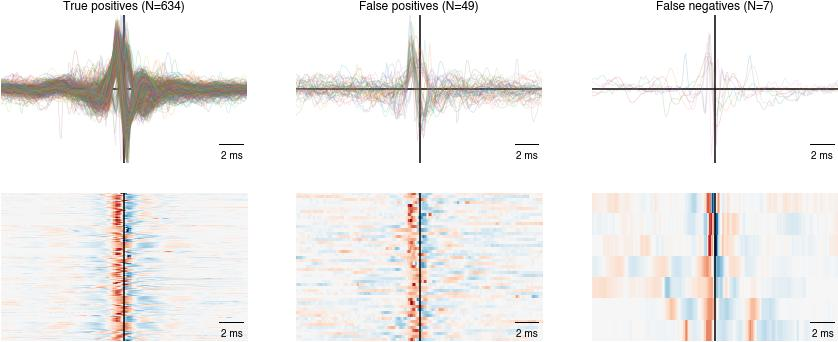

In [9]:
import das.pulse_utils
def plot_pulses(pulseshapes, col=1, title=''):
    win_hw = pulseshapes.shape[0]/2
    plt.subplot(2, 3, col)
    plt.axvline(win_hw, color='k')
    plt.axhline(0, color='k')
    plt.plot(pulseshapes, linewidth=0.75, alpha=0.2)
    plt.ylim(-0.5, 0.5)
    plt.title(title)
    das.utils_plot.scalebar(2, units='ms', dx=0.1)
    das.utils_plot.remove_axes(all=True)
    
    plt.subplot(2, 3, col+3)
    plt.imshow(pulseshapes.T, cmap='RdBu_r')
    plt.clim(-0.5, 0.5)
    plt.axvline(win_hw, color='k')
    das.utils_plot.scalebar(2, units='ms', dx=0.1)
    das.utils_plot.remove_axes(all=True)

win_hw = 100
if pulse_pred_index is not None:
    pulseshapes_pred = das.pulse_utils.get_pulseshapes(pulsetimes_pred * fs + win_hw, x_test, win_hw)
    pulsenorm_pred = np.linalg.norm(np.abs(pulseshapes_pred[50:-50,:]), axis=0)
    pulsefreq_pred = np.array([das.pulse_utils.pulse_freq(p)[0] for p in pulseshapes_pred[50:-50,:].T])
    pulseshapes_pred = np.apply_along_axis(das.pulse_utils.normalize_pulse, axis=-1, arr=pulseshapes_pred.T).T
    tp_pulses = pulseshapes_pred[:, ~nn_pred_pulse.mask]
    fp_pulses = pulseshapes_pred[:, nn_pred_pulse.mask]

    pulseshapes_true = das.pulse_utils.get_pulseshapes(pulsetimes_true * fs + win_hw, x_test, win_hw)
    pulsenorm_true = np.linalg.norm(np.abs(pulseshapes_true[50:-50,:]), axis=0)
    pulsefreq_true = np.array([das.pulse_utils.pulse_freq(p)[0] for p in pulseshapes_true[50:-50,:].T])
    pulseshapes_true = np.apply_along_axis(das.pulse_utils.normalize_pulse, axis=-1, arr=pulseshapes_true.T).T

    fn_pulses = pulseshapes_true[:, nn_true_pulse.mask]

    plt.figure(figsize=(15, 6))
    plot_pulses(tp_pulses, 1, f'True positives (N={tp_pulses.shape[1]})')
    plot_pulses(fp_pulses, 2, f'False positives (N={fp_pulses.shape[1]})')
    plot_pulses(fn_pulses, 3, f'False negatives (N={fn_pulses.shape[1]})')

### Troubleshooting
Things to do when the predictions look weird:
- Plot the raw predictions alongside the input song recording, the labels used for training, and the raw event times. This will reveal whether there is an offset or even a mismatch in sampling frequencies.
- Plot at the shape of false negative and false positive pulses and look for patterns. Maybe there are weird shapes in the false negatives or many "good looking" pulses in the false negatives, indicating problems with the manual annotations.
- Inspect the amplitude and frequency of false negative and false positive pulses and look for patterns. Maybe the network fails for soft pulses

## Evaluate segments
Inspect the post-processed segment labels

/var/folders/bc/5m_c7nkj1vnc2w7xmmnhpfww0000gn/T/ipykernel_51252/953492864.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  segment_labels_true = (y_test[:, segment_pred_index]>0.5).astype(np.float)
/var/folders/bc/5m_c7nkj1vnc2w7xmmnhpfww0000gn/T/ipykernel_51252/953492864.py:35: FutureWarning: Pass y=[ 0.001671  0.00399   0.007664 ... -0.01528  -0.01444  -0.01643 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=512, hop_length=1, power=1)


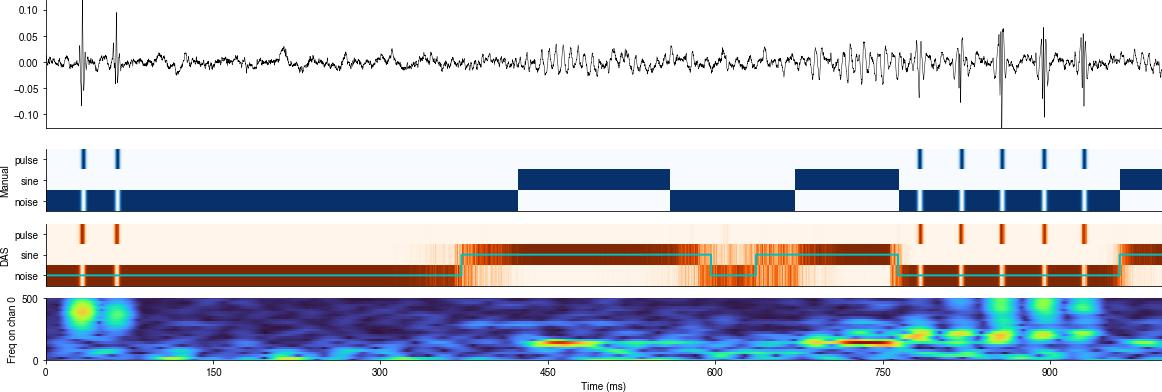

In [10]:
t0 = 55_000
t1 = t0 + 10_000

nb_channels = x_test.shape[1]
x_snippet = x_test[t0:t1,:]

segment_labels_true = (y_test[:, segment_pred_index]>0.5).astype(np.float)
segment_labels_pred = segments['samples']

plt.figure(figsize=(20, 8))

plt.subplot((nb_channels+5)//2, 1, 1)
plt.plot(x_snippet + np.arange(nb_channels)/10, c='k', linewidth=0.5)
plt.xticks([])
plt.axis('tight')

plt.subplot(nb_channels+5,1, 3)
plt.imshow(y_test[t0:t1].T, cmap='Blues')
plt.yticks(range(len(params['class_names'])), labels=params['class_names'])
plt.ylabel('Manual')
plt.xticks([])
das.utils_plot.remove_axes()

plt.subplot(nb_channels+5,1, 4)
plt.imshow(y_pred[t0:t1].T, cmap='Oranges')
plt.plot(segment_labels_pred[t0:t1], linewidth=2, c='c')
plt.yticks(range(len(params['class_names'])), labels=params['class_names'])
plt.ylabel('DAS')
plt.xticks([])
plt.axis('tight')
das.utils_plot.remove_axes()

# compute and display spectrograms for each audio channel
for cnt, x in enumerate(x_snippet.T):
    specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=512, hop_length=1, power=1)
    plt.subplot(nb_channels+5,1, 5+cnt)
    librosa.display.specshow(np.log2(1 + specgram), sr=fs, hop_length=1, y_axis='mel', x_axis='ms', cmap='turbo')
    plt.clim(0, 0.2)
    plt.ylim(0, 500)
    plt.xlim(0, specgram.shape[1] / fs)
    das.utils_plot.remove_axes()
    if cnt<nb_channels-1:
        plt.xticks([])
        plt.xlabel([])
    plt.ylabel(f'Freq on chan {cnt}')

### Sample-wise performance metrics
- precision vs recall for different decision thresholds (color-coded). The closer to the upper right corner the better.   
- F1-score for different decision thresholds. The higher the better.  

              precision    recall  f1-score   support

       noise      0.996     0.987     0.991   1063375
        sine      0.920     0.977     0.947    165628

    accuracy                          0.985   1229003
   macro avg      0.958     0.982     0.969   1229003
weighted avg      0.986     0.985     0.986   1229003



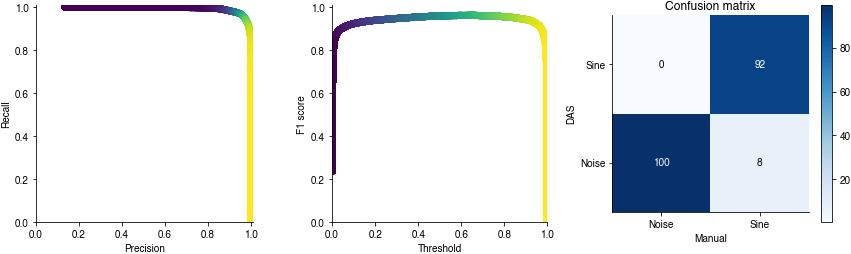

In [11]:

def annot(data, labels=None, ax=None, color_high='w', color_low='k', color_threshold=50):
    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = data

    for x, y in itertools.product(range(data.shape[0]), range(data.shape[1])):
        ax.text(x, y, f'{labels[y, x]:1.0f}', 
                ha='center', va='center', 
                c=color_high if data[x, y]>color_threshold else color_low)

# Calculate PR-curve - this one does not post-process labels (fill gaps, remove short segments)
min_len = min(y_pred.shape[0], y_test.shape[0])
precision, recall, threshold = sklearn.metrics.precision_recall_curve(segment_labels_true[:min_len:10],
                                                                      y_pred[:min_len:10, segment_pred_index])    

f1score = 2 * (precision * recall) / (precision + recall)
threshold_opt = threshold[np.argmax(f1score)]

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(precision[:-1:10], recall[:-1:10], c=threshold[::10])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.axis('square')
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)

plt.subplot(132)
plt.scatter(threshold[:], f1score[:-1], c=threshold[:])
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1.01)


conf_mat, report = das.evaluate.evaluate_segments(y_test[:min_len, segment_pred_index]>0.5, 
                                                  segments['samples'][:min_len],
                                                  np.array(params['class_names'])[[0, segment_pred_index]])
print(report)

conf_mat_norm = 100 * conf_mat/np.sum(conf_mat, axis=0)

plt.subplot(133)
plt.imshow(conf_mat_norm, cmap='Blues')
annot(conf_mat_norm)
plt.xticks((0, 1), labels=['Noise', 'Sine'])
plt.yticks((0, 1), labels=['Noise', 'Sine'])
plt.xlabel('Manual')
plt.ylabel('DAS')
plt.title('Confusion matrix')
plt.axis('square')
plt.colorbar()
plt.show()


### Evaluate segment timing

10000
{'FP': 11, 'TP': 33, 'FN': 6, 'precision': 0.75, 'recall': 0.8461538461538461, 'f1_score': 0.7951807228915662}
{'FP': 11, 'TP': 33, 'FN': 6, 'precision': 0.75, 'recall': 0.8461538461538461, 'f1_score': 0.7951807228915662}
Temporal errors of all predicted sine onsets: 10.20 ms
Temporal errors of all predicted sine offsets: 12.10 ms


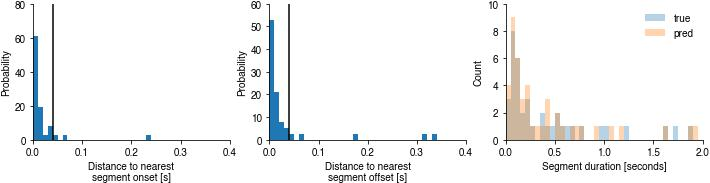

In [12]:
def fixlen(onsets, offsets):
    if len(onsets) > len(offsets):
        onsets = onsets[:-1]
    elif len(offsets) > len(onsets):
        offsets = offsets[1:]
    return onsets, offsets
    
tol = .04  # seconds = 40ms
print(fs)
if segment_pred_index is not None:
    segment_onset_times_true, segment_offset_times_true = fixlen(*das.evaluate.segment_timing(segment_labels_true, fs))
    segment_onset_times_pred, segment_offset_times_pred = fixlen(*das.evaluate.segment_timing(segment_labels_pred, fs))
    
    durations_true = segment_offset_times_true - segment_onset_times_true
    durations_pred = segment_offset_times_pred - segment_onset_times_pred

    segment_onsets_report, segment_offsets_report, nearest_predicted_onsets, nearest_predicted_offsets = das.evaluate.evaluate_segment_timing(segment_labels_true, segment_labels_pred, fs, tol)

    print(segment_onsets_report)
    print(segment_offsets_report)
    print(f'Temporal errors of all predicted sine onsets: {np.median(nearest_predicted_onsets)*1000:1.2f} ms')
    print(f'Temporal errors of all predicted sine offsets: {np.median(nearest_predicted_offsets)*1000:1.2f} ms')
    
    plt.figure(figsize=(12, 2.5))
    plt.subplot(131)
    plt.hist(nearest_predicted_onsets, bins=np.arange(0, 10 * tol, .01), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to nearest\nsegment onset [s]')
    plt.ylabel('Probability');
    das.utils_plot.remove_axes()

    plt.subplot(132)
    plt.hist(nearest_predicted_offsets, bins=np.arange(0, 10 * tol, .01), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to nearest\nsegment offset [s]')
    plt.ylabel('Probability');
    das.utils_plot.remove_axes()

    plt.subplot(133)
    plt.hist(durations_true, bins=np.arange(0, 2, 0.05), histtype='bar', label='true', alpha=0.33)
    plt.hist(durations_pred, bins=np.arange(0, 2, 0.05), histtype='bar', label='pred', alpha=0.33)
    plt.xlabel('Segment duration [seconds]')
    plt.ylabel('Count')
    plt.legend()
    das.utils_plot.remove_axes()